<a href="https://colab.research.google.com/github/stesforz/Covid19/blob/main/Rt_EpiEstim_DPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages("EpiEstim") ## It may take a while !!! 
install.packages("dplyr")
install.packages("zoo")

In [ ]:
library(EpiEstim)
library(ggplot2)
library(scales)
library(dplyr)
library(zoo)

In [131]:
##df <-  read.csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')
df <-  read.csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
df[,1] <- as.Date(df[,1], format = "%Y-%m-%d") # converto la data as.Date

df <- df[,c("data","nuovi_positivi","totale_casi")]
df$"casi_incidenti" <- df$"totale_casi" - lag(df$"totale_casi",1)
df$"casi_incidenti"[c(1)] <- df$"totale_casi"[c(1)]
df$"casi_incidenti_MM7" <- round(rollmean(x = df$"casi_incidenti", 7, fill = NA, align = 'right'))
df$"nuovi_positivi_MM7" <- round(rollmean(x = df$"nuovi_positivi", 7, fill = NA, align = 'right'))

df <- na.omit(df)
df$"casi_importati" <- 0
df$"casi_importati"[c(1)] <- df$"casi_incidenti_MM7"
df$"casi_incidenti_MM7"[c(1)] <- 0

curva.epidemica <- df[,c("data","casi_incidenti_MM7","casi_importati")]
names(curva.epidemica) <- c("dates", "local", "imported") # assegno i nomi richiesti dal pacchetto EpiEstim



Warning message in df$casi_importati[c(1)] <- df$casi_incidenti_MM7:
“number of items to replace is not a multiple of replacement length”


In [ ]:
df

,data,nuovi_positivi,totale_casi,casi_incidenti,casi_incidenti_MM7,casi_importati,diff
,<date>,<int>,<int>,<int>,<dbl>,<dbl>,<int>
7,2020-03-01,566,1694,566,0,242,0
8,2020-03-02,342,2036,342,258,0,0
9,2020-03-03,466,2502,466,311,0,0
10,2020-03-04,587,3089,587,384,0,0
11,2020-03-05,769,3858,769,458,0,0
12,2020-03-06,778,4636,778,535,0,0
13,2020-03-07,1247,5883,1247,679,0,0
14,2020-03-08,1492,7375,1492,812,0,0
15,2020-03-09,1797,9172,1797,1019,0,0


In [ ]:
min(curva.epidemica$local)

[1] 0

In [ ]:
## parametri dell'intervallo seriale stimati da dati di contact tracing lombardi
shape.stimato <- 1.87
rate.stimato <- 0.28
N <- 300 ## massimo numero di giorni dell'intervallo seriale

## definisco la distribuzione dell'intervallo seriale
intervallo.seriale <- dgamma(0:N, shape=shape.stimato, rate=rate.stimato) 
## normalizzo la distribuzione dell'intervallo seriale in modo che la somma faccia 1
SI <- (intervallo.seriale/sum(intervallo.seriale)) 

In [ ]:
  ## calcolo la stima di R applicando la funzione estimate_R del pacchetto EpiEstim
  stima <- estimate_R(incid=curva.epidemica, method="non_parametric_si", config = make_config(list(si_distr = SI, n1=10000, mcmc_control=make_mcmc_control(thin=1, burnin=1000000))))
  
  ## il pacchetto avvisa che la stima di Rt viene fornita con una media mobile settimanale ("Default config will estimate R on weekly sliding windows"), eventualmente personalizzabile
  ## avvisa inoltre che la parte iniziale della curva non e' sufficiente alla stima corretta della variabilita' di Rt ("You're estimating R too early in the epidemic to get the desired posterior CV")
  
  ###################
  ### Attenzione! ###
  ###################
  
  ## La stima e' calcolata su tutta la curva epidemica specificata, ma il pacchetto non puo' tenere conto dei ritardi di inserimento nel dato
  ## Le stime di Rt varieranno man mano che vengono inseriti nuovi casi con data di inizio sintomi indietro nel tempo
  ## Per questo motivo ISS considera valide le stime fino a 16 giorni prima della data in cui viene effettuata la stima.
  ## Questo ritardo puo' cambiare su base regionale
  
  ## estraggo i risultati di interesse
  R.medio <- stima$R$`Mean(R)` ## valore medio
  R.lowerCI <- stima$R$`Quantile.0.025(R)` ## estremo inferiore dell'intervallo di confidenza
  R.upperCI <- stima$R$`Quantile.0.975(R)` ## estremo superiore dell'intervallo di confidenza
  
  ## estraggo le date di riferimento per la stima di R
  ## la data rappresenta il giorno centrale intorno a cui e' calcolata la media mobile di Rt (con finestra di ampiezza pari a una settimana)
  ## per scelta di chi mette a disposizione il pacchetto, non saranno disponibili stime per i primi 4 giorni di dati e per gli ultimi 3
  sel.data.centrale <- rowMeans(stima$R[, c("t_start", "t_end")])
  sel.data.riferimento <- stima$R[,"t_end"]
  sel.data.dal <- stima$R[,"t_start"]
  sel.data.al <- stima$R[,"t_end"]
  
  #data <- curva.epidemica[sel.data.centrale,1]
  data <- curva.epidemica[sel.data.riferimento,1]
  data.dal <- curva.epidemica[sel.data.dal,1]
  data.al <- curva.epidemica[sel.data.al,1]
  CE <- curva.epidemica[sel.data.centrale,2]

Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 



In [ ]:
 ## metto i risultati in una tabella
stima.R <- data.frame(data = data, dal = data.dal, al = data.al, Casi.locali = CE, Rt.medio = R.medio, CI.inferiore = R.lowerCI, CI.superiore = R.upperCI)

In [ ]:
## Nei grafici aggiungo un rettangolo grigio per gli ultimi grey.last giorni: la stima non è affidabile"
grey.xmax.RT <- max(stima.R$data)
grey.xmin.RT <- grey.xmax.RT -12
grey.ymax.RT  <- max(stima.R$CI.superiore)

In [ ]:
curva.epidemica30 <- tail(curva.epidemica, n = 30 + 12) ## considero solo gli ultimi days.last + gray.last giorni

In [ ]:
stima.R30 <- tail(stima.R, n = 90 + 12) ## considero solo gli ultimi days.last + gray.last giorni

In [ ]:
options(repr.plot.width=40, repr.plot.height=15)

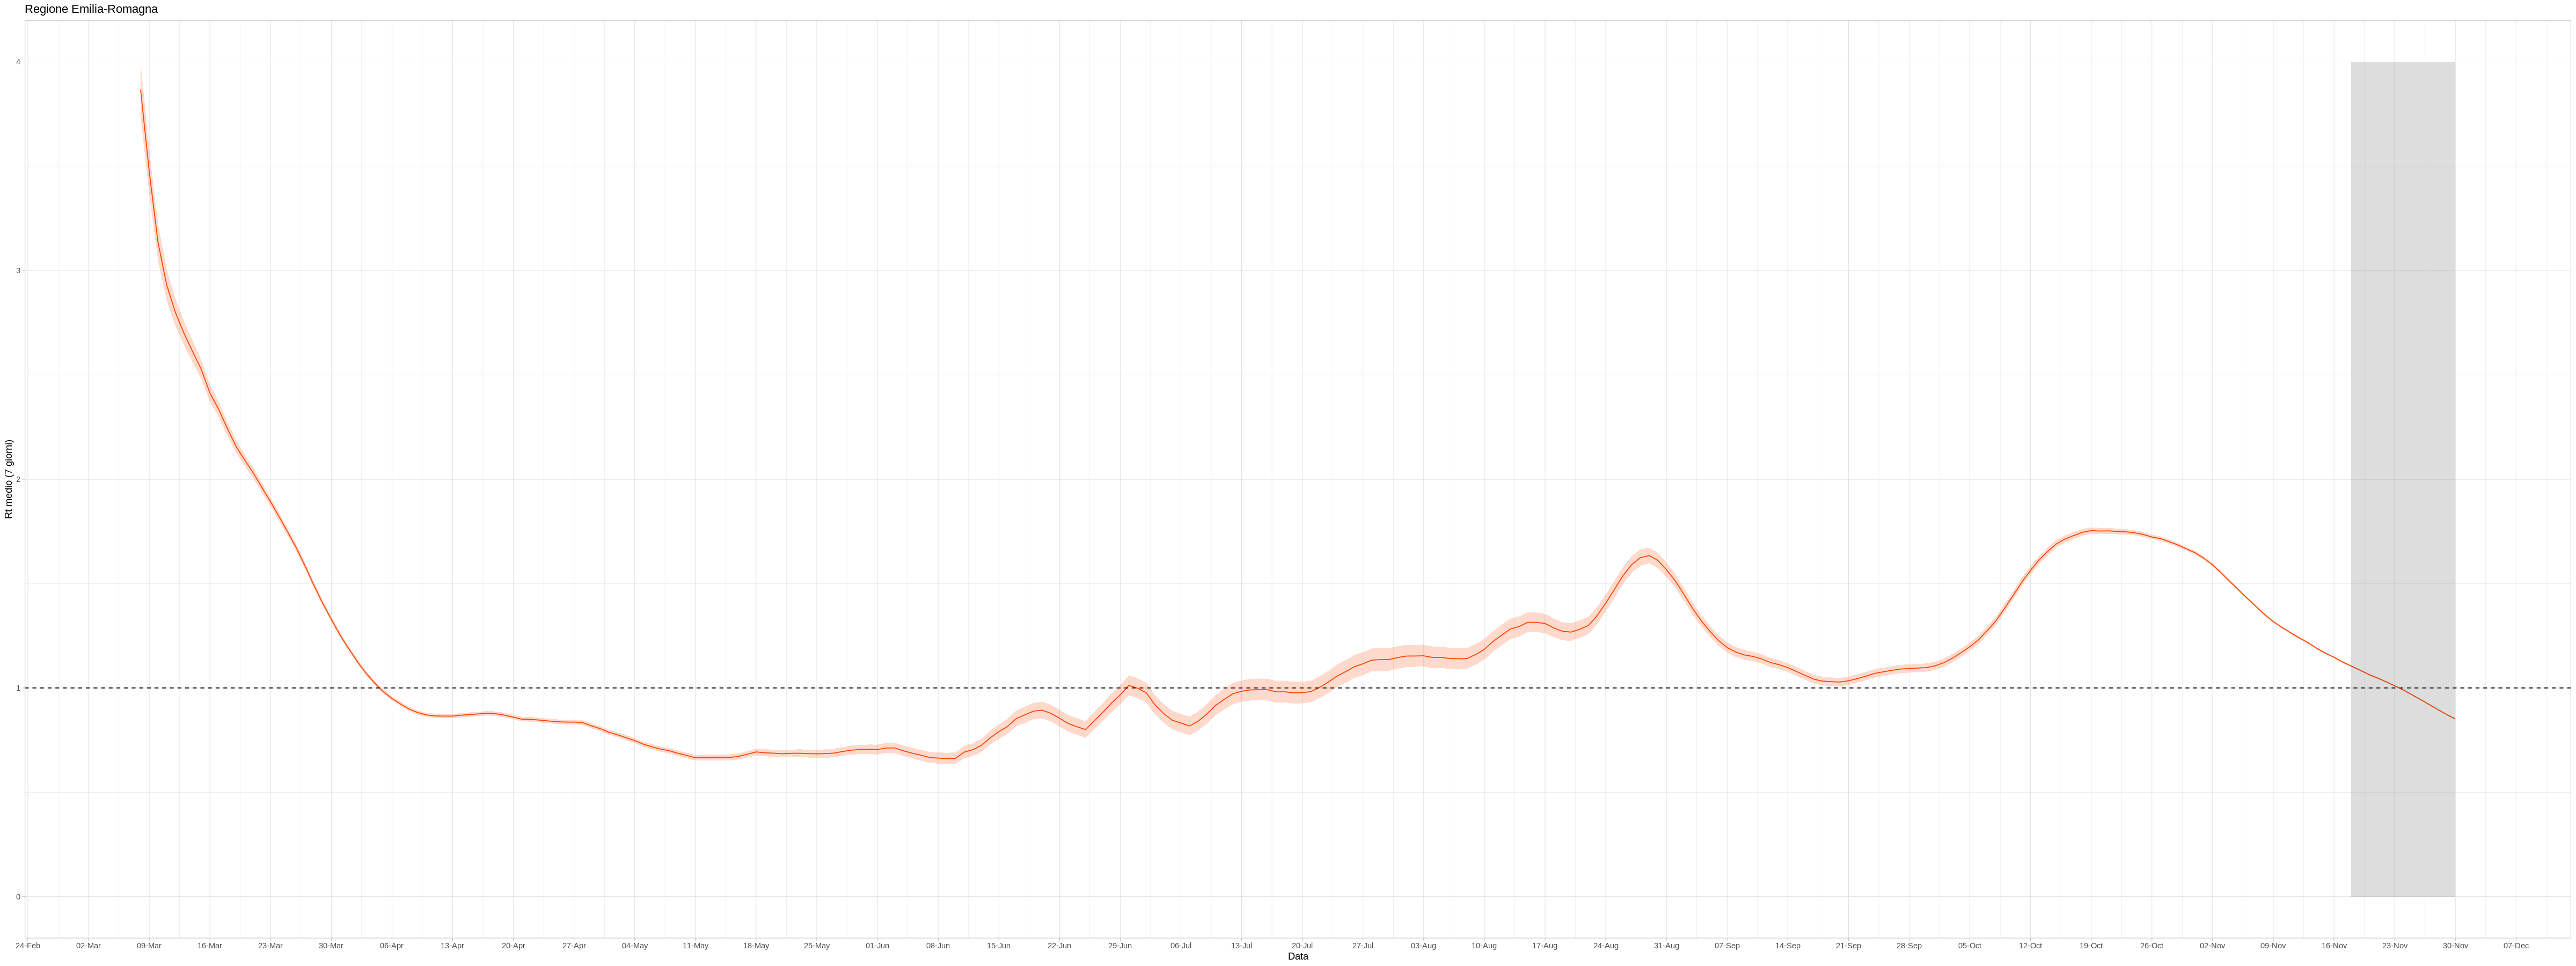

In [ ]:
## Rt
pRt <- ggplot(stima.R,aes(x = data, y=Rt.medio)) +
  geom_line(color = "orangered") +
  geom_hline(yintercept = 1, linetype = 'dashed') +
  geom_ribbon(
    aes(ymin = CI.inferiore, ymax = CI.superiore), 
    fill =  "orangered", 
    alpha = 0.2
  ) +
  xlab("Data") + ylab(paste0("Rt medio (7 giorni)")) +
  ggtitle("Regione Emilia-Romagna") +
  annotate("rect", xmin = grey.xmin.RT, xmax = grey.xmax.RT, ymin = 0, ymax = grey.ymax.RT, alpha = 0.2) +
  scale_x_date(labels = date_format("%d-%b"), breaks = '1 week') +
  theme_light()
  
pRt

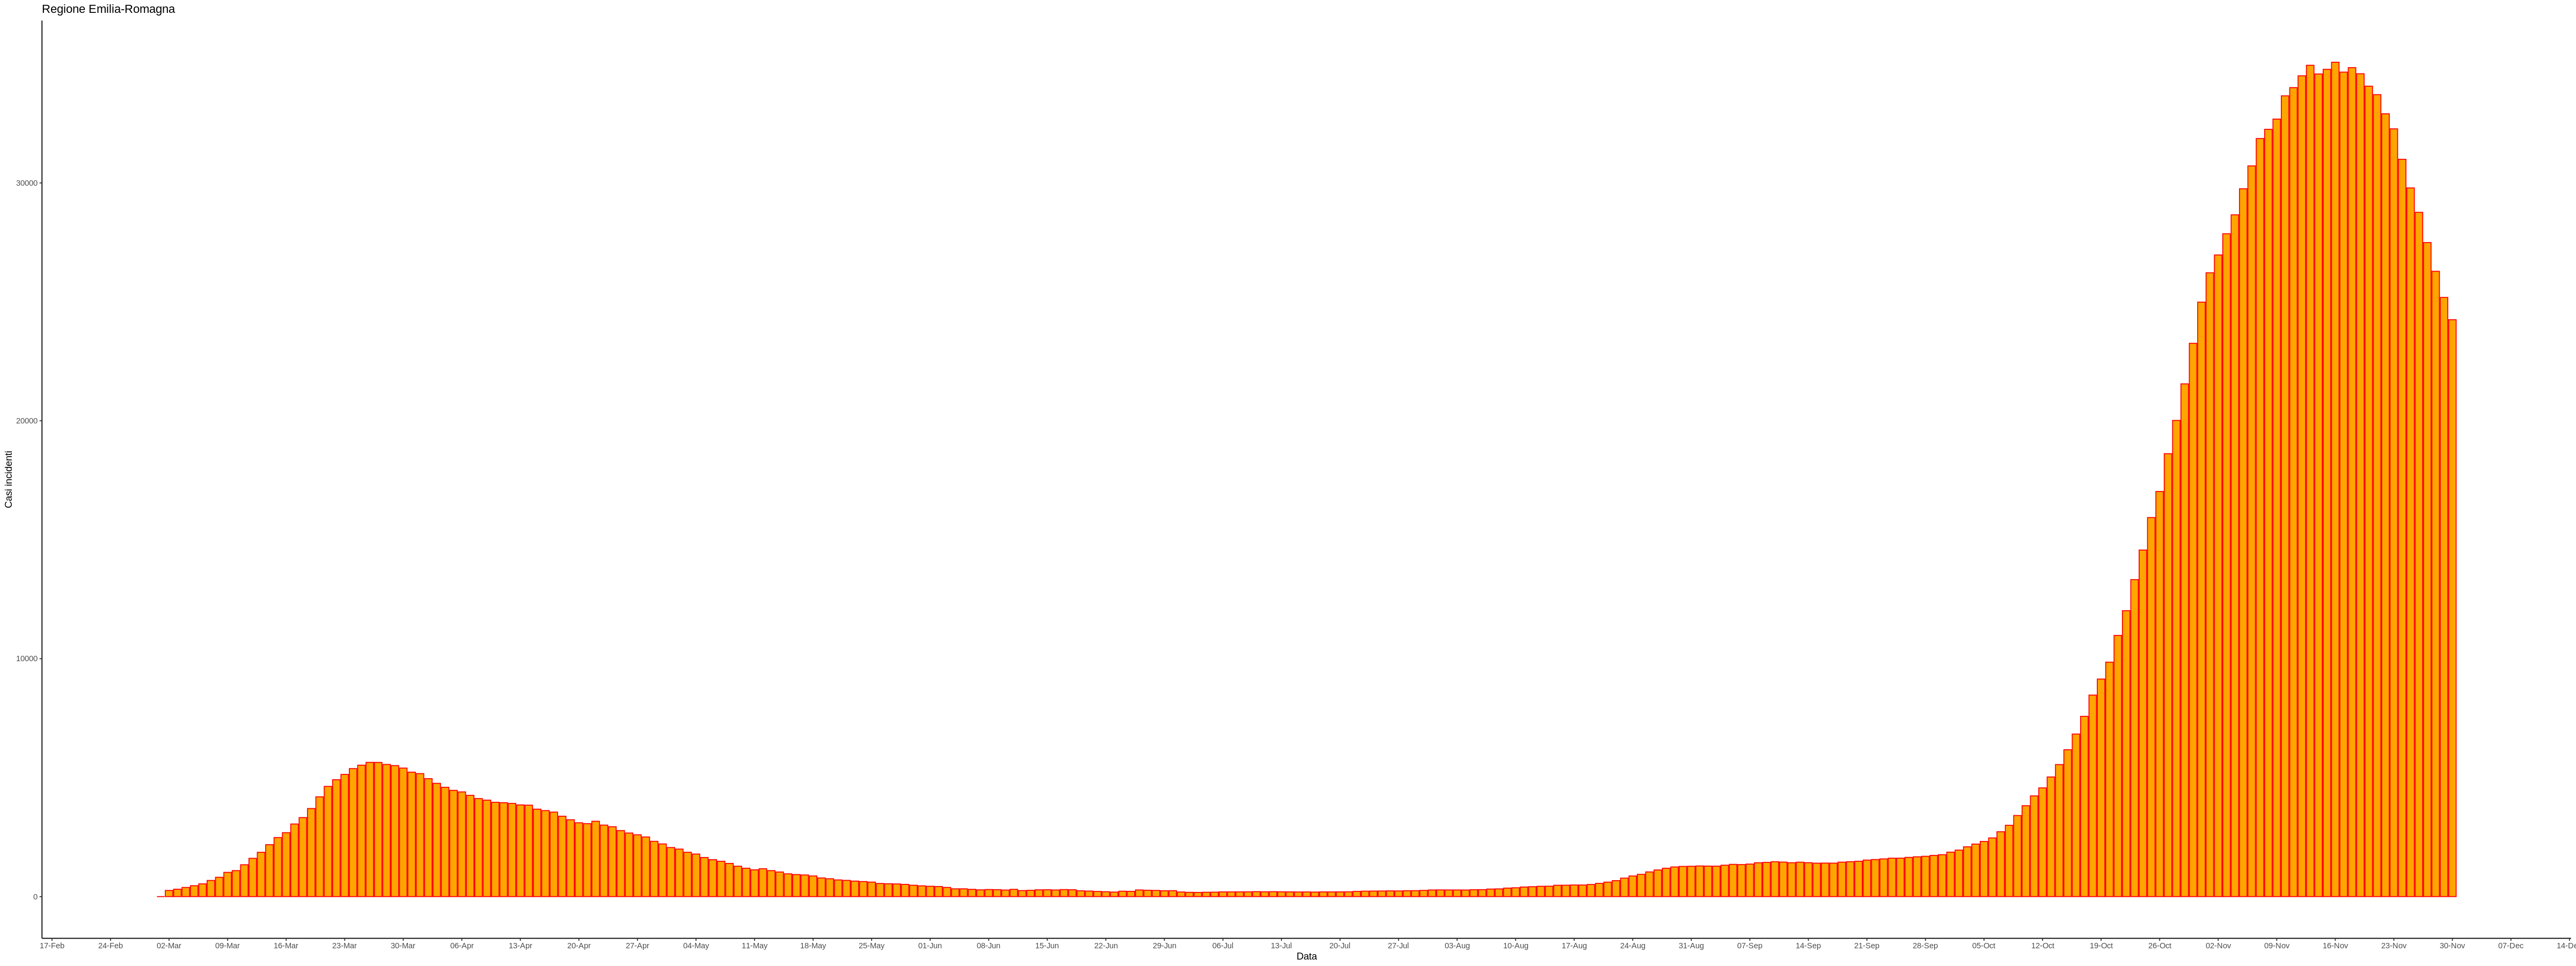

In [ ]:
  pCEBP <- ggplot(df,aes(x = data, y=casi_incidenti_MM7)) +
    geom_bar(stat = "identity", color = "red", fill = "orange") +
    xlab("Data") + ylab("Casi incidenti") +
    ggtitle("Regione Emilia-Romagna") +
    annotate("rect", alpha = 0.2) +
    scale_x_date(labels = date_format("%d-%b"), breaks = '1 week') +
    theme_classic()
  
  pCEBP